## Objectif
L'objectif de ce notebook est de mettre en évidence les qualités des modèles pré-entrainé sur le dataset qu'on a, alors on va évaluer les modèles suivants : 
- Alexnet
- Resnet-101
- Inception-Resnet-V2

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import tensorflow_hub as hub

from PIL.Image import Image
import cv2 as cv

import datetime

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2

In [3]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

In [15]:
batch_size = 32
img_height = 224
img_width = 224
data_root = "./Dataset/train"

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [16]:
class_names = np.array(train_ds.class_names)
print(class_names)

['MildDemented' 'ModerateDemented' 'NonDemented' 'VeryMildDemented']


On normalise maintenant de 0 à 1 

In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [19]:
result_batch = classifier.predict(train_ds)

24576/10484 [======================================================================] - 0s 0us/step


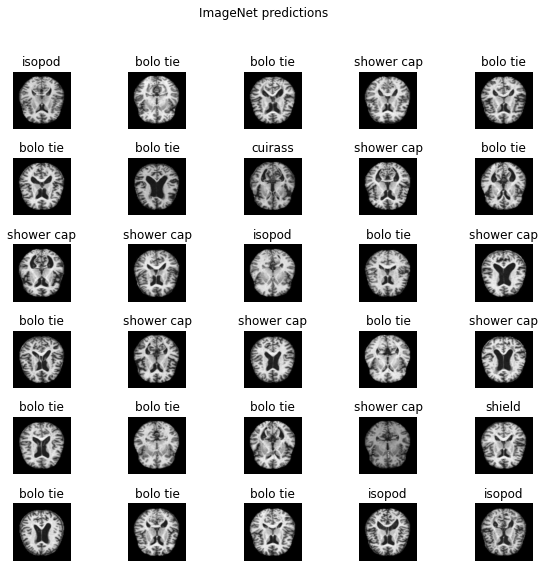

In [20]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

C'est pourquoi il faut faire un transfer learning et non pas directement utiliser un modèle pré-entrainé. 

Un transfert learning peut s'effectuer de différentes façon, on peut ré-entrainé tout le modèle, on peut prendre une partie du modèle ou bien juste entrainé la dernière couche du modèle sur notre dataset. On commence par un test avec le mobilenet

In [21]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [22]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [23]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [24]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [27]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 4])

In [28]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [31]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [32]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
129/129 [==============================] - 204s 1s/step - loss: 0.9658 - acc: 0.5448 - val_loss: 0.8827 - val_acc: 0.5693
Epoch 2/10
129/129 [==============================] - 191s 1s/step - loss: 0.8536 - acc: 0.6021 - val_loss: 0.9487 - val_acc: 0.5410
Epoch 3/10
129/129 [==============================] - 194s 2s/step - loss: 0.8035 - acc: 0.6390 - val_loss: 0.8198 - val_acc: 0.6377
Epoch 4/10
129/129 [==============================] - 194s 1s/step - loss: 0.7630 - acc: 0.6607 - val_loss: 0.7773 - val_acc: 0.6348
Epoch 5/10
129/129 [==============================] - 194s 1s/step - loss: 0.7532 - acc: 0.6495 - val_loss: 0.7613 - val_acc: 0.6416
Epoch 6/10
129/129 [==============================] - 192s 1s/step - loss: 0.7121 - acc: 0.6798 - val_loss: 0.7708 - val_acc: 0.6270
Epoch 7/10
129/129 [==============================] - 222s 2s/step - loss: 0.6857 - acc: 0.6942 - val_loss: 0.7491 - val_acc: 0.6611
Epoch 8/10
129/129 [==============================] - 198s 2s/step - 

In [33]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


In [34]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

['NonDemented' 'NonDemented' 'NonDemented' 'NonDemented' 'NonDemented'
 'NonDemented' 'VeryMildDemented' 'VeryMildDemented' 'NonDemented'
 'VeryMildDemented' 'MildDemented' 'NonDemented' 'NonDemented'
 'VeryMildDemented' 'VeryMildDemented' 'VeryMildDemented' 'NonDemented'
 'NonDemented' 'VeryMildDemented' 'NonDemented' 'VeryMildDemented'
 'NonDemented' 'VeryMildDemented' 'NonDemented' 'NonDemented'
 'VeryMildDemented' 'VeryMildDemented' 'VeryMildDemented' 'MildDemented'
 'VeryMildDemented' 'NonDemented' 'NonDemented']


In [36]:
model.evaluate(train_ds, batch_size=32)

129/129 [==============================] - 149s 1s/step - loss: 0.6171 - acc: 0.7479


[0.6171481609344482, 0.747864305973053]